## Read NYU's Data from ABIDE-BIDS and Preprocess
This notebook contains the workflow of reading and processing the raw fMRI data of NYU's site in ABIDE 

1. Read NYU's BIDS format data


Layout object that will help me query the data in BIDS format

In [228]:
from bids.grabbids import BIDSLayout


Layout object takes as parameter the directory that contains the subjects

In [229]:
layout = BIDSLayout("/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/")

In [230]:
!tree /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/

/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/
├── participants.tsv
├── sub-0050952
│   ├── anat
│   │   └── sub-0050952_T1w.nii.gz
│   └── func
│       └── sub-0050952_task-rest_run-1_bold.nii.gz
├── sub-0050953
│   ├── anat
│   │   └── sub-0050953_T1w.nii.gz
│   └── func
│       └── sub-0050953_task-rest_run-1_bold.nii.gz
├── sub-0050954
│   ├── anat
│   │   └── sub-0050954_T1w.nii.gz
│   └── func
│       └── sub-0050954_task-rest_run-1_bold.nii.gz
├── sub-0050955
│   ├── anat
│   │   └── sub-0050955_T1w.nii.gz
│   └── func
│       └── sub-0050955_task-rest_run-1_bold.nii.gz
├── sub-0050956
│   ├── anat
│   │   └── sub-0050956_T1w.nii.gz
│   └── func
│       └── sub-0050956_task-rest_run-1_bold.nii.gz
├── sub-0050957
│   ├── anat
│   │   └── sub-0050957_T1w.nii.gz
│   └── func
│       └── sub-0050957_task-rest_run-1_bold.nii.gz
├── sub-0050958
│   ├── anat
│   │   └── sub-0050958_T1w.nii.gz
│   └── func
│       └── sub-0050958_task-rest_run-1_bold.nii.gz
├── sub-0050959
│   ├── an

**Lets query about the data now**

1. Get the subject ID's 

In [231]:
layout.get_subjects()

['0050952',
 '0050953',
 '0050954',
 '0050955',
 '0050956',
 '0050957',
 '0050958',
 '0050959',
 '0050960',
 '0050961',
 '0050962',
 '0050964',
 '0050965',
 '0050966',
 '0050967',
 '0050968',
 '0050969',
 '0050970',
 '0050971',
 '0050972',
 '0050973',
 '0050974',
 '0050975',
 '0050976',
 '0050977',
 '0050978',
 '0050979',
 '0050980',
 '0050981',
 '0050982',
 '0050983',
 '0050984',
 '0050985',
 '0050986',
 '0050987',
 '0050988',
 '0050989']

`2`. What are modalities of the data in the database? Though it is not very difficult to find that, as you can look at the folders as they follow a unform structure.  

In [232]:
layout.get_modalities()

['anat', 'func']

In [233]:
layout.get_types()

['bold', 'T1w']

`3.` Getting all the details of an individual subject. Note that it given an object of Type *File*.

In [234]:
layout.get(subject='0050952')

[File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz', type='T1w', modality='anat', subject='0050952'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050952')]

If you look at one of the outputs -> File() , Notice the parameters: `type`,`task`, `run`, `task`, `subject` etc.
Remember these terms. You need to use these to query BIDS.

For a specific subset of data. Note that we are using extension filter to get just the imaging data (BIDS allows both .nii and .nii.gz so we need to include both)

In [235]:
layout.get(subject='0050952', type='bold', extensions=['nii', 'nii.gz'])

[File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050952')]

### Including pyBIDS in workflow
Let's create our own custom BIDSDataGrabber using a Function Interface.

In [236]:
# from bids.grabbids import BIDSLayout

In [237]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    bold = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return bold

In [238]:
get_nifti_filenames('0050952',"/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/")

['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz']

Lets wrap it inside a Node object.

In [239]:
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function

In [240]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names='func_file_path'), name='BIDSDataGrabber')


Note that in above line the `input_names` should be same as the actual parmeters of `function` whereas the `output_names` and `name` can be different.

Next, lets provide the inputs to our `BIDSDatagrabber` Node. The Workflow discussed later depends on these inputs

In [241]:
BIDSDataGrabber.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
BIDSDataGrabber.inputs.subject_id = '0050954'

Execute the Node using `run()` and store all the outputs inside an object variable named `res` (here).  

If this is run again without any changes to it, it collects the precomputed result from cache and doesnot excute again. Saves time! It is useful when you have incorporated it (`BIDSDataGrabber`) in workflow and some other node changes which does not influence its (`BIDSDataGrabber`) inputs. Then instead of re-executing the `BIDSDataGrabber` node again, it just fetches the result from the cache.

In [242]:
# res = BIDSDataGrabber.run()

Lets see the output's type - It is of Interface result type. The actual result is stored in it in res.outputs

In [243]:
# res

To see the outputs stored in this object

In [244]:
# res.outputs

### Let's create a Workflow with a dummy function Node and our BIDSDataGrabber Node
Let's assume that our dummy function that takes as input the path, analyzes it and then returns the path 

In [245]:
def dummy_analyze(path):
    print("\n\nANALYZING " + str(path) + "\n\n")
    path_analyzed = "Analyzed: " + str(path)
    return path_analyzed
    

Create a Node of it.

In [246]:
processed_BOLD = Node(Function(function=dummy_analyze,input_names=['path'],
                               output_names=['path_analyzed']),name='dummy_analyze')

Now Create a Workflow and connect two nodes - `processed_BOLD` and `BIDSDataGrabber`

In [247]:
wf=Workflow(name='Analysis_pipeline')


There are two different ways to call ``Analysis_pipeline``:

    connect(source, "source_output", dest, "dest_input")

    connect([(source, dest, [("source_output1", "dest_input1"),
                             ("source_output2", "dest_input2")
                             ])
             ])

With the first approach you can establish one connection at a time. With the second you can establish multiple connects between two nodes at once. In either case, you're providing it with four pieces of information to define the connection:

- The source node object
- The name of the output field from the source node
- The destination node object
- The name of the input field from the destination node


In [248]:
wf.connect(BIDSDataGrabber,'func_file_path',processed_BOLD,'path')
wf.run()

170914-20:04:16,780 workflow INFO:
	 Workflow Analysis_pipeline settings: ['check', 'execution', 'logging']
170914-20:04:16,794 workflow INFO:
	 Running serially.
170914-20:04:16,799 workflow INFO:
	 Executing node BIDSDataGrabber in dir: /tmp/tmp2QTKOx/Analysis_pipeline/BIDSDataGrabber
170914-20:04:16,852 workflow INFO:
	 Executing node dummy_analyze in dir: /tmp/tmp8AWbSe/Analysis_pipeline/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz']




Note in the above code that the name of the output field from the source node i.e. `func_file_path` and 
the name of the input field i.e. `path` from the destination node must be same as described in their respective Nodes

Display Workflow Graph

170914-20:04:18,84 workflow INFO:
	 Converting dotfile: /tmp/tmpG3VNng/BIDSDataGrabber/workflow_graph.dot to png format


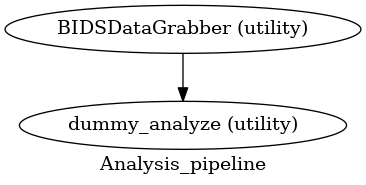

In [249]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")

In [250]:
# Specify the base directory for the working directory
wf.base_dir = "working_dir"

# Execute the workflow
wf.run()

170914-20:04:18,106 workflow INFO:
	 Workflow Analysis_pipeline settings: ['check', 'execution', 'logging']
170914-20:04:18,113 workflow INFO:
	 Running serially.
170914-20:04:18,115 workflow INFO:
	 Executing node BIDSDataGrabber in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/BIDSDataGrabber
170914-20:04:18,186 workflow INFO:
	 Executing node dummy_analyze in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz']




The specification of ``base_dir`` is very important (and is why we needed to use absolute paths above), because otherwise all the outputs would be saved somewhere in the temporary files. Unlike interfaces, which by default spit out results to the local directry, the Workflow engine executes things off in its own directory hierarchy.

Next, Getting metadata using `layout.get_metadata('<brain_file_path>')`

In [254]:
x = layout.get_metadata('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050953/func/sub-0050952_task-rest_run-1_bold.nii.gz')

In [269]:
y = x.items()[1]

In [272]:
y[1]

90

## Iterating over subject labels
Till now we demostrated how to use `pybids` to "analyze" one subject. How can we scale it for all subjects? Easy - using `iterables`.

In [252]:
BIDSDataGrabber.iterables = ('subject_id', layout.get_subjects())
wf.run()

170914-20:04:18,410 workflow INFO:
	 Workflow Analysis_pipeline settings: ['check', 'execution', 'logging']
170914-20:04:18,473 workflow INFO:
	 Running serially.
170914-20:04:18,475 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a22 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050975/BIDSDataGrabber
170914-20:04:18,524 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a01 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050953/BIDSDataGrabber
170914-20:04:18,569 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a11 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050964/BIDSDataGrabber
170914-20:04:18,609 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a31 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050984/BIDSDataGrabber
170914-20:04:18,651 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a18 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/wor



ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050968/func/sub-0050968_task-rest_run-1_bold.nii.gz']


170914-20:04:19,635 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a27 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050980/BIDSDataGrabber
170914-20:04:19,676 workflow INFO:
	 Executing node dummy_analyze.a27 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050980/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050980/func/sub-0050980_task-rest_run-1_bold.nii.gz']


170914-20:04:19,686 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a03 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050955/BIDSDataGrabber
170914-20:04:19,726 workflow INFO:
	 Executing node dummy_analyze.a17 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050970/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/dat



ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050974/func/sub-0050974_task-rest_run-1_bold.nii.gz']


170914-20:04:20,447 workflow INFO:
	 Executing node dummy_analyze.a23 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050976/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050976/func/sub-0050976_task-rest_run-1_bold.nii.gz']


170914-20:04:20,458 workflow INFO:
	 Executing node dummy_analyze.a28 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050981/dummy_analyze


ANALYZING ['/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050981/func/sub-0050981_task-rest_run-1_bold.nii.gz']


170914-20:04:20,469 workflow INFO:
	 Executing node BIDSDataGrabber.aI.a09 in dir: /tmp/tmpG3VNng/BIDSDataGrabber/working_dir/Analysis_pipeline/_subject_id_0050961/BIDSDataGrabber
170914-20:04:20,510 workflow INFO:
	 Executing node dummy_analyze.a09 in dir: /tmp/tmpG3VNng/BIDSDataG

In [253]:
BIDSDataGrabber.outputs


func_file_path = <undefined>